In [1]:
import numpy as np
import pandas as pd
import random
from math import sqrt, exp, log, floor
from functools import partial
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline

In [2]:
def standardize(data):
    d_mean = np.mean(data)
    d_stddev = np.std(data, ddof=1)
    if d_stddev == 0:
        return data
    return np.array([ (d-d_mean)/d_stddev for d in data ])

In [3]:
# Batch Gradient Descent

def data_converged(theta_prime, theta, p, tol):
    return sqrt(sum([ (theta_prime[i] - theta[i])**2 for i in range(p) ])) < tol

# dJ: gradient of J
# alpha: learning rate
# tol: tolerance
# init_theta: vector of inital values for theta
# max_num_rounds: max iterations of the algorithm
# x_data: x data points
# y_data: y data points
def batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data):
    p = len(dJ)
    assert(p == len(init_theta))
    assert(p == np.array(x_data).shape[1])
    assert(len(x_data) == len(y_data))
    
    theta = init_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = [theta[i] - alpha * dJ[i](theta, x_data, y_data) for i in range(p)]
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
            
    return theta

In [4]:
# example for using lasso with batch GD

def dotp(x1, x2):
    return sum([x1i*x2i for (x1i,x2i) in zip(x1,x2)])

def dtheta_di_lasso(lam, i, theta, x_data, y_data):
    accum = 0.0
    for (xj,yj) in zip(x_data,y_data):
        xji = xj[i]
        accum += -2 * xji * (yj - dotp(theta,xj)) + lam*abs(theta[i])/theta[i]
    return accum

def lasso_batch_gd(lam, x_data, y_data):
    p = np.array(x_data).shape[1]
    alpha = 0.0001
    tol = 0.0001
    init_theta = np.array([0. for _ in range(p)])
    #init_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    #init_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 100
    dJ = [ partial(dtheta_di_lasso, lam, i) for i in range(p) ]
    return batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data)

In [5]:
# Pathwise Coordinate Descent

def nej(j, e, k):
    return 0 if k == j else e

def sum_nej(xi, theta, j):
    return sum([ nej(j, xi[k]*theta[k], k) for k in range(len(theta)) ])

def soft_thresh(a):
    return max(a, 0)

def sign(a):
    # we can define sign(0) = 1 without any harm here because of the assert on lam in S
    return 1 if a >= 0 else -1
    
def S(t, B):
    assert(B >= 0)
    return sign(t)*soft_thresh(abs(t) - B)

# A template for Pathwise CD.  A and B are parameters that depend on the objective function
# we wish to maximize
def pathwise_cd(A, B, x_data, y_data):
    assert(A >= 0)
    assert(B >= 0)
    assert(len(x_data.shape) == 2) # x_data must be 2D
    assert(len(y_data.shape) == 1) # y_data must be 1D
    N = x_data.shape[0]
    p = x_data.shape[1]
    assert(N >= 2)
    assert(N == y_data.shape[0])
    
    initial_theta = np.array([0. for _ in range(p)])
    #initial_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    #initial_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 1000
    tol = 0.0001
    
    theta = initial_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = theta.copy()
        for j in range(p):
            theta_prime[j] = S( sum([ xi[j]*(yi - sum_nej(xi,theta_prime,j))
                                        for (xi,yi) in zip(x_data,y_data) ]) / A,
                                B)
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
        
    return theta

In [6]:
# pathwise CD implementations depending on the objective function we wish to maximize

def lasso_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    return pathwise_cd(N-1, lam, x_data, y_data)

def elastic_net_pathwise_cd(alpha, lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam*alpha
    B = lam*(1-alpha)
    return pathwise_cd(A, B, x_data, y_data)

def ridge_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam
    B = lam # should be 0 for ridge, but we're going to try something
    return pathwise_cd(A, B, x_data, y_data)

In [7]:
################################################################################################
############### Everything below is testing for the various algorithms above ###################
################################################################################################

In [8]:
# data generation

def unif_simulation(a, b, N=1):
    return np.random.uniform(a, b, N)

def normal_simulation(mean, stddev, N):
    return np.random.normal(mean, stddev, N)

def e():
    return normal_simulation(0, np.sqrt(4), 1)[0]
    
def e_err():
    if unif_simulation(1,100) <= 10:
        if unif_simulation(1,2) == 1:
            return normal_simulation(0, np.sqrt(4), 1)[0] + 5
        else:
            return normal_simulation(0, np.sqrt(4), 1)[0] - 5
    else:
        return normal_simulation(0, np.sqrt(4), 1)[0]

def Y(f, x):
    return f(x) + e()

# creates a (n x p) design matrix
def create_design_mat(x_data, max_order):
    data = []
    for order in range(max_order + 1):
        data.append(standardize([d ** order for d in x_data]))
    return np.array(data).T

def calc_yhat(theta, x):
    max_order = len(theta)
    xvals = [x ** order for order in range(max_order+1)]
    return sum([theta_i*x_i for (theta_i,x_i) in zip(theta,xvals)])

In [9]:
def mse(y, y_hat):
    n = y.shape[0]
    assert(n == y_hat.shape[0])
    assert(len(y.shape) == 1)
    assert(len(y_hat.shape) == 1)
    return sum([ (yi-yi_hat)**2 for (yi,yi_hat) in zip(y,y_hat) ]) / n

def validate(y_data, design, model):
    y_hats = np.array([ model @ xi for xi in design ])
    return mse(y_data, y_hats)

def test(algo, lam, f, p):
    N = 50
    M = 5000
    width = 100
    
    x_data_train = unif_simulation(-width, width, N)
    y_data_train = standardize([Y(f, x) for x in x_data_train])
    design_train = create_design_mat(x_data_train, p)
    model = algo(lam, design_train, y_data_train)
    print(model)
    
    x_data_valid = unif_simulation(-width, width, M)
    y_data_valid = standardize([Y(f, x) for x in x_data_valid])
    design_valid = create_design_mat(x_data_valid, p)
    mse = validate(y_data_valid, design_valid, model)
    return mse

In [10]:
# K-fold cross validation

def randomly_shuffle(x_data, y_data):
    xd = list(x_data.copy())
    yd = list(y_data.copy())
    x_shuff = []
    y_shuff = []
    while len(yd) > 0:
        idx = random.randrange(0, len(yd))
        x_shuff.append(xd.pop(idx))
        y_shuff.append(yd.pop(idx))
    return np.array(x_shuff), np.array(y_shuff)

def partition_data(k, x_data, y_data):
    N = len(y_data)
    sz = int(N/k)
    partitions = []
    for _ in range(int(k)):
        xd = x_data[0:sz]
        yd = y_data[0:sz]
        partitions.append((xd,yd))
        x_data = x_data[sz:None]
        y_data = y_data[sz:None]
    assert(x_data.shape[0] == 0)
    assert(y_data.shape[0] == 0)
    return partitions

def create_folds(partitions):
    folds = []
    for i in range(len(partitions)):
        xs = []
        ys = []
        for j in range(len(partitions)):
            if j != i:
                xs.extend(partitions[j][0])
                ys.extend(partitions[j][1])
        folds.append((np.array(xs),np.array(ys)))
    return folds

def k_cross_validation(k, algo, lam, x_data, y_data):
    N = len(y_data)
    assert(N % k == 0) # for uniform group sizes
    x_data, y_data = randomly_shuffle(x_data, y_data)
    partitions = partition_data(k, x_data, y_data)
    folds = create_folds(partitions)
    theta_hats = [algo(lam, xd, yd) for xd,yd in folds]
    assert(len(partitions) == k)
    assert(len(folds) == k)
    assert(len(theta_hats) == k)
    
    # individual partitions are used for validation error
    errors = [validate(yd,xd,theta_hat) for (xd, yd), theta_hat in zip(partitions, theta_hats)]
    return sum(errors) / k

def cv_plot(plot, errors, lams, desc, xlbl='lambda'):
    min_idx = np.argmin(errors)
    plot.plot(lams, errors, color='b')
    plot.axvline(x=lams[min_idx], color='r')
    #plot.ylim(bottom=-0.5, top=2)
    plot.xlabel(xlbl)
    plot.ylabel('MSE')
    plot.title(desc + ' - CV training error')
    #plot.show()

In [11]:
def gen_data_1D(f, N):
    width = 2
    x_data = unif_simulation(-width, width, N)
    x_data = x_data.reshape((N,1))
    y_data = standardize([Y(f, x[0]) for x in x_data])
    return x_data, y_data

def create_lams(a, b, N, c=0):
    return [ c + a + (b-a)*i/N for i in range(N) ]

In [12]:
################################################################################################
########################### Training and Testing for each algorithm ############################
################################################################################################

In [13]:
f = lambda x: -2*x + x**2
N = 20
x_data, y_data = gen_data_1D(f, N)

In [14]:
def read_data(fname):
    data = pd.read_csv(fname)
    x_data = np.array([ row[0:-1] for row in data.values])
    y_data = np.array([ row[-1] for row in data.values])
    return x_data, y_data, data.columns

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def month_indicator(i, month):
    midx = np.where(months == month)
    return 1 if i == midx else 0

def data_design_mat(data):
    design = []
    for row in data:
        numerical = row[0:-1]
        month = row[-1]
        drow = list(numerical)
        for i in range(12):
            drow.append(month_indicator(i, month))
        design.append(standardize(drow))
    return np.array(design)

In [15]:
# testing

colors = ['blue', 'green', 'brown', 'purple', 'yellow', 'lawngreen', 'darkblue', 'olive', 'greenyellow', 'silver']
def plot_lams(plot, errors, algo, lams, x_data, y_data, desc, xlbl='lambda'):
    min_idx = np.argmin(errors)
    plot.axvline(x=lams[min_idx], color='r')
    thetas = []
    for lam in lams:
        thetas.append(algo(lam, x_data, y_data))
    for p in range(len(thetas[0])):
        theta_is = [theta[p] for theta in thetas]
        plot.plot(lams, theta_is, color=colors[p%len(colors)], label=p)
    #plot.ylim(bottom=-0.5, top=2)
    plot.xlabel(xlbl)
    plot.ylabel('theta_i')
    plot.title(desc + ': theta v. ' + xlbl)

def test_algo(algo, x_data, y_data, c, desc):
    design = data_design_mat(x_data)
    a = 0
    b = 1.5
    lams = create_lams(a, b, 50, c)
    k = 5
    errors = [k_cross_validation(k, algo, lam, design, y_data) for lam in lams]
    min_idx = np.argmin(errors)
    best_lam = lams[min_idx]
    best_error = errors[min_idx]
    
    print("{} CV error: {} (lam={})".format(desc,best_error,best_lam))
    cv_plot(plt, errors, lams, desc)
    plt.show()
    plot_lams(plt, errors, algo, lams, design, y_data, desc)
    plt.show()
    return best_lam

def test_algo_file(algo, training_file, test_file, c, desc):
    # CV to figure out the best lambda value
    x_data, y_data, cols = read_data(training_file)
    best_lam = test_algo(algo, x_data, y_data, c, desc)
    design = data_design_mat(x_data)
    theta_hat = algo(best_lam, design, y_data)
    params = list(filter(lambda i: theta_hat[i] != 0, range(len(theta_hat))))
    print("params selected: {}".format(params))
    #print("theta_hat: {}".format(theta_hat))

    # determine the test error
    test_x_data, test_y_data, _ = read_data(test_file)
    test_design = data_design_mat(test_x_data)
    test_err = validate(test_y_data, test_design, theta_hat)
    print("test error: {}".format(test_err))
    
def test_fn(algo, c):
    test = "data/test.csv"
    n_lt_p = "data/n_lt_p.csv"
    n_eq_p = "data/n_eq_p.csv"
    n_gt_p = "data/n_gt_p.csv"
    test_algo_file(algo, n_lt_p, test, c, 'n<p')
    test_algo_file(algo, n_eq_p, test, c, 'n=p')
    test_algo_file(algo, n_gt_p, test, c, 'n>p')

n<p CV error: 1.2453422214406413 (lam=0.59)


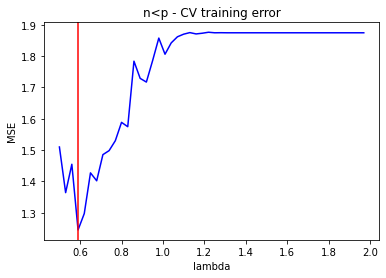

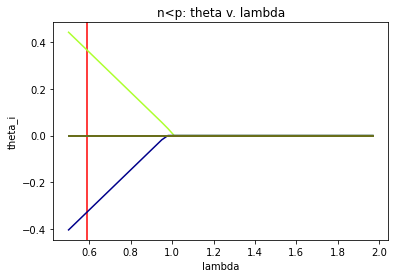

params selected: [8, 26]
test error: 1.4627047721642459
n=p CV error: 0.6425180954851757 (lam=0.5)


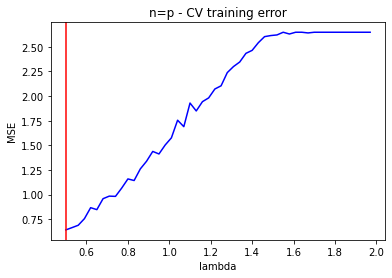

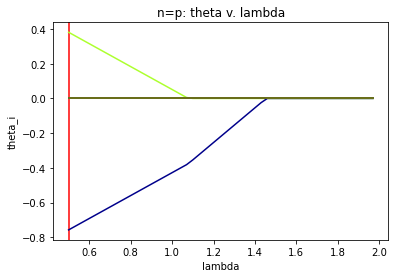

params selected: [8, 26]
test error: 0.8970443673687024
n>p CV error: 0.5745537069487552 (lam=0.5)


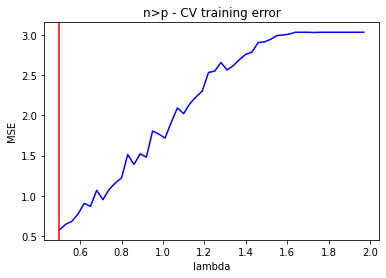

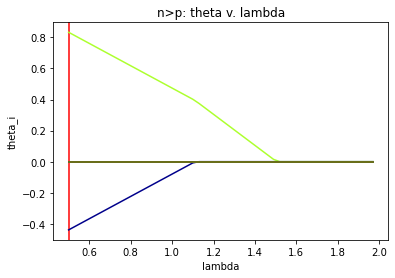

params selected: [8, 26]
test error: 0.5576900887610639


In [16]:
# LASSO
test_fn(lasso_pathwise_cd, 0.5)

n<p CV error: 1.1037872806736657 (lam=0.5)


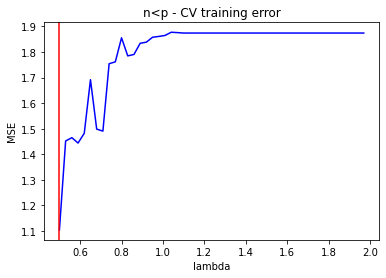

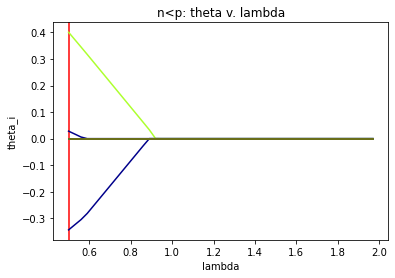

params selected: [6, 8, 26]
test error: 1.3457523368718234
n=p CV error: 0.6458862319950706 (lam=0.5)


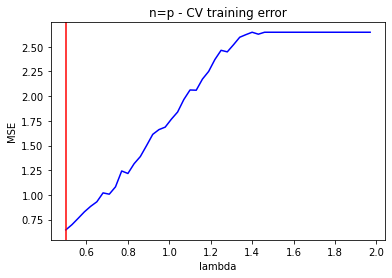

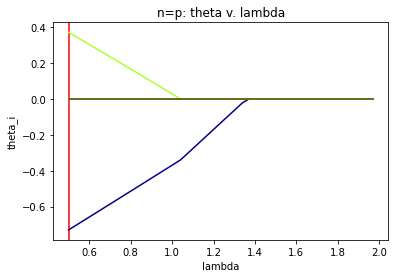

params selected: [8, 26]
test error: 0.9334642872928125
n>p CV error: 0.6715707973434333 (lam=0.5)


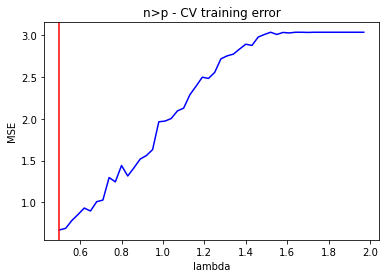

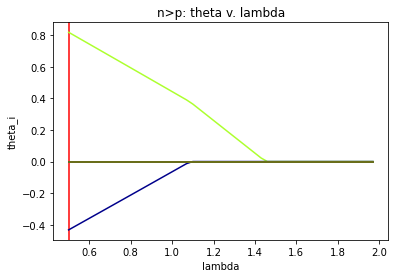

params selected: [8, 26]
test error: 0.5806312970553524


In [17]:
# Ridge w/ST
test_fn(ridge_pathwise_cd, 0.5)

<ipython-input-3-f26be0645092>:4: RuntimeWarning: overflow encountered in double_scalars
  return sqrt(sum([ (theta_prime[i] - theta[i])**2 for i in range(p) ])) < tol
<ipython-input-9-54bfaf27f0ba>:6: RuntimeWarning: overflow encountered in double_scalars
  return sum([ (yi-yi_hat)**2 for (yi,yi_hat) in zip(y,y_hat) ]) / n


elastic net CV error: 0.8547484231280288 (lam=1.9,alpha=0.9)


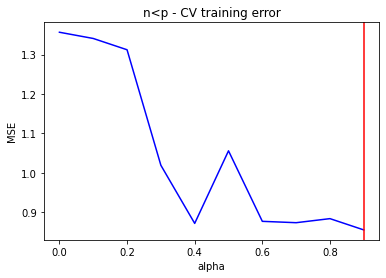

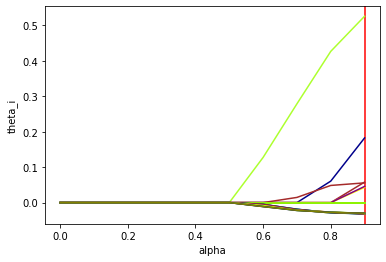

params selected: [6, 8, 12, 14, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: 0.9058332385797991
elastic net CV error: 0.29207417302266103 (lam=0.7,alpha=0.8)


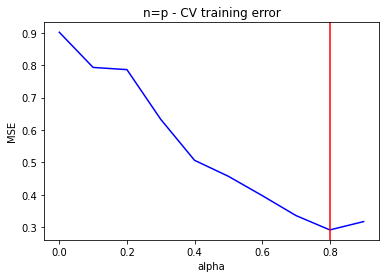

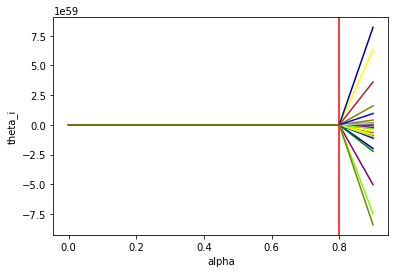

params selected: [8, 15, 26]
test error: 0.49728826378831154
elastic net CV error: 0.197633619916317 (lam=1.0,alpha=0.9)


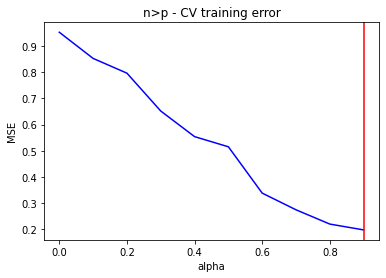

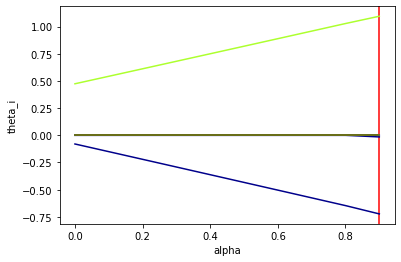

params selected: [0, 6, 8, 26]
test error: 0.18518423657395663


In [18]:
# Elastic Net
def plot_alphas(plot, errors, algo, lam, alphas, x_data, y_data, desc, xlbl='alpha'):
    min_idx = np.argmin(errors)
    plot.axvline(x=alphas[min_idx], color='r')
    thetas = []
    for alpha in alphas:
        thetas.append(algo(alpha, lam, x_data, y_data))
    for p in range(len(thetas[0])):
        theta_is = [theta[p] for theta in thetas]
        plot.plot(alphas, theta_is, color=colors[p%len(colors)], label=p)
    #plot.ylim(bottom=-0.5, top=2)
    plot.xlabel(xlbl)
    plot.ylabel('theta_i')
    
def test_algo_en(algo, x_data, y_data, c, desc):
    design = data_design_mat(x_data)
    a = 0
    b = 1.5
    alphas = create_lams(0, 1, 10, 0)
    lams = create_lams(a, b, 5, c)
    k = 5
    err_vals = []
    lam_vals = []
    for alpha in alphas:
        errors = [k_cross_validation(k, partial(algo,alpha), lam, design, y_data) for lam in lams]
        min_idx = np.argmin(errors)
        best_lam = lams[min_idx]
        best_error = errors[min_idx]
        err_vals.append(best_error)
        lam_vals.append(best_lam)
    
    min_idx = np.argmin(err_vals)
    best_error = err_vals[min_idx]
    best_lam = lam_vals[min_idx]
    best_alpha = alphas[min_idx]
    
    print("elastic net CV error: {} (lam={},alpha={})".format(best_error,best_lam,best_alpha))
    cv_plot(plt, err_vals, alphas, desc, 'alpha')
    plt.show()
    plot_alphas(plt, err_vals, algo, best_lam, alphas, design, y_data, desc)
    plt.show()
    return best_lam, best_alpha

def test_algo_file_en(algo, training_file, test_file, c, desc):
    # CV to figure out the best lambda value
    x_data, y_data, cols = read_data(training_file)
    best_lam, best_alpha = test_algo_en(algo, x_data, y_data, c, desc)
    design = data_design_mat(x_data)
    theta_hat = algo(best_alpha, best_lam, design, y_data)
    params = list(filter(lambda i: theta_hat[i] != 0, range(len(theta_hat))))
    print("params selected: {}".format(params))
    #print("theta_hat: {}".format(theta_hat))

    # determine the test error
    test_x_data, test_y_data, _ = read_data(test_file)
    test_design = data_design_mat(test_x_data)
    test_err = validate(test_y_data, test_design, theta_hat)
    print("test error: {}".format(test_err))
    
def test_fn_en(algo, c):
    test = "data/test.csv"
    n_lt_p = "data/n_lt_p.csv"
    n_eq_p = "data/n_eq_p.csv"
    n_gt_p = "data/n_gt_p.csv"
    test_algo_file_en(algo, n_lt_p, test, c, 'n<p')
    test_algo_file_en(algo, n_eq_p, test, c, 'n=p')
    test_algo_file_en(algo, n_gt_p, test, c, 'n>p')
    
test_fn_en(elastic_net_pathwise_cd, 0.7)

<ipython-input-4-419916d37454>:10: RuntimeWarning: invalid value encountered in double_scalars
  accum += -2 * xji * (yj - dotp(theta,xj)) + lam*abs(theta[i])/theta[i]


n<p CV error: nan (lam=0.5)


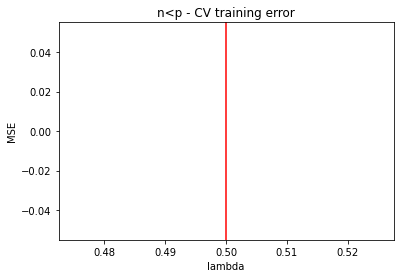

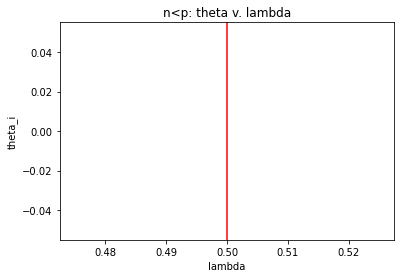

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: nan
n=p CV error: nan (lam=0.5)


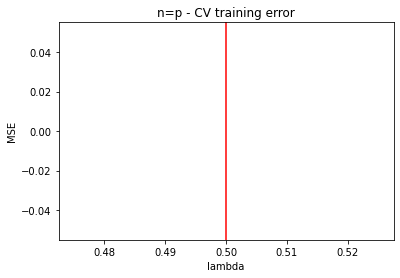

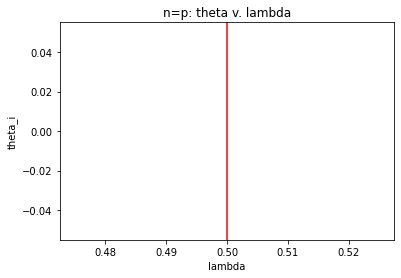

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: nan
n>p CV error: nan (lam=0.5)


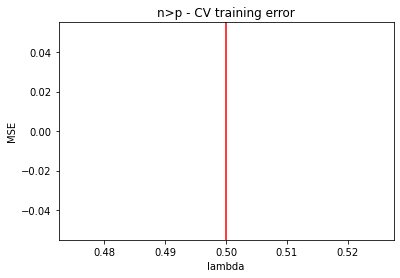

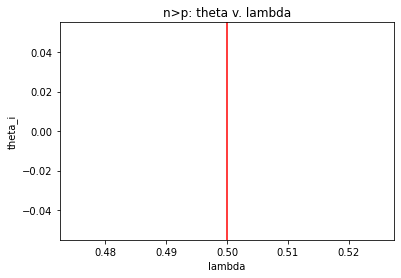

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: nan


In [19]:
# LASSO GD
test_fn(lasso_batch_gd, 0.5)